In [102]:
import glob, os, sys
import math

import numpy as np
import pandas as pd
import xarray as xr
import scipy.interpolate

import matplotlib.pyplot as plt

from icenet2.model.models import linear_trend_forecast
from icenet2.data.sic.mask import Masks

In [103]:
land_mask = Masks().get_land_mask()
ds = xr.open_mfdataset([
    "data/osisaf/north/siconca/2010.nc",
    "data/osisaf/north/siconca/2011.nc",
    "data/osisaf/north/siconca/2012.nc",
    "data/osisaf/north/siconca/2013.nc"
], parallel=True)

In [171]:
size, timesteps = 100, 3
x, y, dt = 100, 200, pd.to_datetime("2014-12-3")
xdx = slice(x, x + size)
ydx = slice(y, y + size)
#da = ds.isel(xc=xdx, yc=ydx, time=slice(idx, idx+timesteps)).to_array().isel(variable=0)
da = ds.isel(xc=xdx, yc=ydx).sel(time=[
    pd.to_datetime("{}-{}-{}".format(yr, dt.strftime("%m"), dt.strftime("%d"))) 
    for yr in range(2010, int(dt.strftime("%Y")))
]).to_array().isel(variable=0)
land_mask = land_mask[xdx, ydx]

In [172]:
#da.values = np.array([
#    [[0.0, 0.9],[0.2, 0.5]],
#    [[0.3, 0.7],[0.2, 0.4]],
#    [[0.6, 0.5],[0.3, 0.5]],
#])
da

<xarray.DataArray (time: 4, yc: 100, xc: 100)>
dask.array<getitem, shape=(4, 100, 100), dtype=float64, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2010-12-03 2011-12-03 2012-12-03 2013-12-03
    lon       (yc, xc) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * xc        (xc) float64 -2.888e+03 -2.862e+03 -2.838e+03 ... -437.5 -412.5
  * yc        (yc) float64 387.5 362.5 337.5 ... -2.062e+03 -2.088e+03
    lat       (yc, xc) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    variable  <U8 'ice_conc'

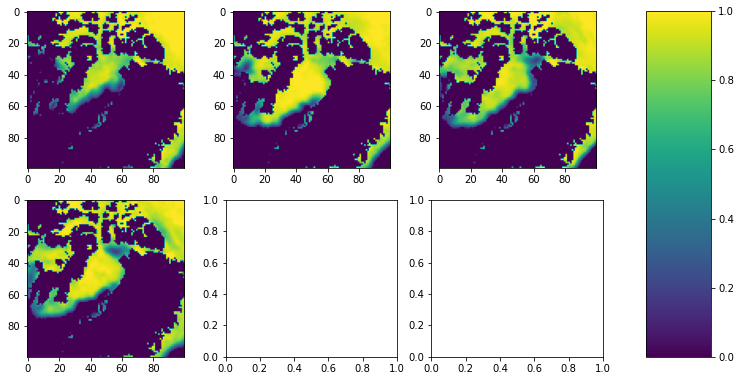

In [173]:
fig, ax = plt.subplots(round(len(da.time.values) / 3 + 0.5), 3, figsize=(12, round(len(da.time.values) / 3 + 0.5) * 3))
for i, dt in enumerate(da.time.values):
    im = ax[int(np.floor(i / 3))][i % 3].imshow(da.sel(time=dt), vmin=0., vmax=1.)#, levels=10)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(im, cax=cax)

In [174]:
da.time

<xarray.DataArray 'time' (time: 4)>
array(['2010-12-03T00:00:00.000000000', '2011-12-03T00:00:00.000000000',
       '2012-12-03T00:00:00.000000000', '2013-12-03T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2010-12-03 2011-12-03 2012-12-03 2013-12-03
    variable  <U8 'ice_conc'

In [175]:
#da.where(da.time < pd.to_datetime("2012-05-01"), drop=True)

In [176]:
def data_selector(da,
                  processing_date,
                  missing_dates=tuple()):
    target_date = pd.to_datetime(processing_date)

    date_da = da[(da.time['time.month'] == target_date.month) &
             (da.time['time.day'] == target_date.day) &
             (da.time <= target_date) &
             ~da.time.isin(missing_dates)].\
    isel(time=slice(0, 35))
    #date_da = da.where((da.time <= target_date) & ~da.time.isin(missing_dates), drop=True)
    return date_da.compute()

output_map = linear_trend_forecast(
                    data_selector, dt, da, land_mask,
                    missing_dates=(),
                    shape=da.values.shape[-2:])

[0 1 2 3]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0 1]
 [1 1]
 [2 1]
 [3 1]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.      0.      0.      ... 0.99585 0.9944  0.99195]
 [0.      0.      0.      ... 0.9955  0.9927  0.98705]
 [0.      0.      0.      ... 0.99295 0.9897  0.98485]
 ...
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]]


In [177]:
output_map.min(), output_map.max()

(0.0, 1.0)

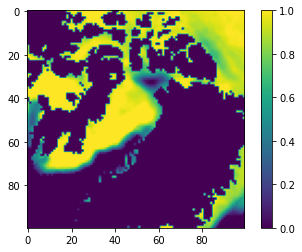

In [178]:
fig, ax = plt.subplots()
cm = ax.imshow(output_map, vmin=0., vmax=1.)
plt.colorbar(cm)

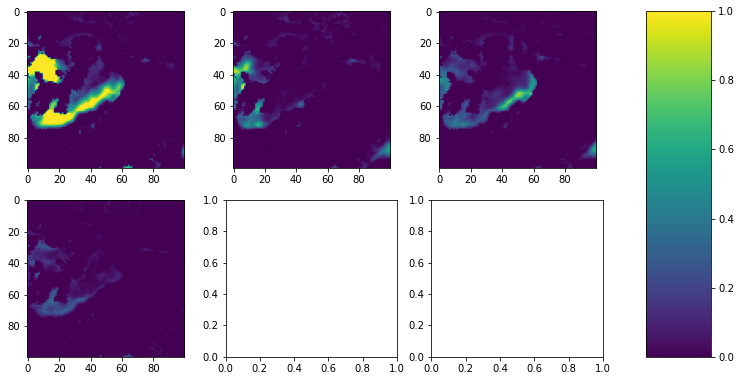

In [179]:
fig, ax = plt.subplots(round(len(da.time.values) / 3 + 0.5), 3, figsize=(12, round(len(da.time.values) / 3 + 0.5) * 3))
for i, dt in enumerate(da.time.values):
    im = ax[int(np.floor(i / 3))][i % 3].imshow(output_map - da.sel(time=dt), vmin=0., vmax=1.)#, levels=10)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(im, cax=cax)

In [180]:
count = output_map[output_map > 0].shape[0]

(array([0.01528384, 0.02869619, 0.04491578, 0.06456644, 0.08889582,
        0.12039925, 0.16968185, 0.29039301, 0.46631316, 1.        ]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 10 artists>)

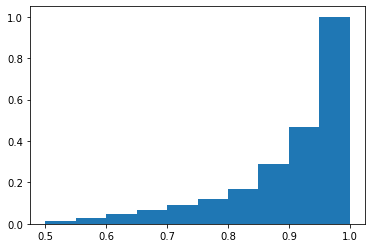

In [181]:
fig, ax = plt.subplots()
ax.hist(output_map[output_map > 0], bins=np.linspace(0.5, 1.0, 11), density=True, cumulative=True)

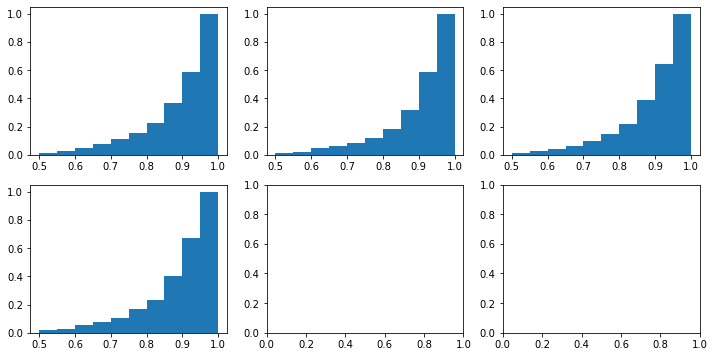

In [182]:
fig, axs = plt.subplots(round(len(da.time.values) / 3 + 0.5), 3, figsize=(12, round(len(da.time.values) / 3 + 0.5) * 3))
for i, dt in enumerate(da.time.values):
    sic_vals = da.sel(time=dt).values
    ax = axs[int(np.floor(i / 3))][i % 3]
    ax.hist(sic_vals[sic_vals > 0], bins=np.linspace(0.5, 1.0, 11), density=True, cumulative=True)